# **TBRC ROI (Region of Interest) Selection**
Author: Michael Kainola

Date: August 1, 2022

This notebook demonstrates the key steps for selecting the ROI for the TBRC monitor. The goal of this exercise was to identify the ROI which had a luminosity measurement that best correlated with the TBRC temperature. The data from the 'best' ROI would later be used in training the TBRC forecasting model. Three candidate ROIs were provided by the site experts. This code quantifies the luminosity at all three ROIs, and then calculates the correlation with the TBRC temperature data.

<br>

**Step 1. Load the external dependencies.**

In [23]:
#import standard modules
from matplotlib import pyplot as plt
import numpy as np
import cv2 # for image processing
import sys # for importing custom module
import pandas as pd # for visualizations
import seaborn as sn # for visualizing the correlation matrix
from statistics import mean # to perform binning

# import custom module
sys.path.insert(0, '../Common Files') #add Common Files folder to the system path
from cv_support import * #custom function for reading/writing CSVs, recording video

<br>

**Step 2. Load ROI coordinates and temperature data (from PI).**

In [24]:
# import the ROI coordinates
rois = readROICoords("Inputs/roi_coords.csv")

_roi1 = rois[0]
_roi2 = rois[1]
_roi3 = rois[2]

# import the historian temperature data
PI_DATA = importPIData()

Reading ROI coordinates from: Inputs/roi_coords.csv

Reading historian (temperature) data from: Inputs/historian_temperature_data.csv



<br>

**Step 3. Define function for visualizing the ROI and temperature data**

In [25]:
# creates visualization for ROI and temperature data
def createChart(x, y, y2, y3, y4, y5):
    
    #clear the figure
    plt.clf()
    
    #set the figure size
    fig, ax = plt.subplots(figsize = (11, 7))

  
    # add a secondary axis for the historian/temperature data
    ax2 = ax.twinx()
    
    
    # plot the overall image brightness
    ax.plot(
        x, 
        y, 
        color='k', 
        linestyle='--', 
        linewidth=1,
        label="Image brightness"
    )
    
    # plot the ROI1 brightness
    ax.plot(
        x, 
        y2, 
        color='b', 
        linestyle='--', 
        linewidth=1,
        label="ROI1 brightness"
    )
    
    # plot the ROI2 brightness
    ax.plot(
        x, 
        y3, 
        color='g', 
        linestyle='--', 
        linewidth=1,
        label="ROI2 brightness"
    )
    
    # plot the ROI3 brightness
    ax.plot(
        x, 
        y4, 
        color='r', 
        linestyle='--', 
        linewidth=1,
        label="ROI3 brightness"
    )
    
    # plot the temperature data
    ax2.plot(
        x, 
        y5, 
        color='m', 
        linestyle='--', 
        linewidth=1,
        #marker=".", #"o", "."
        label="PI Temperature"
    )

    # rotate the x ticks
    plt.xticks(rotation=90)
    
    # set axis labels
    ax.set_xlabel('Frame')
    ax.set_ylabel('Brightness')
    ax2.set_ylabel('Temperature')
  
    # set plot title
    plt.title("Avg pixel brightness by frame vs Temperature")

    # set legend locations
    ax.legend(loc=2) # axis 1 - upper left
    ax2.legend(loc=1) # axis 2 - upper right
    plt.show()

<br>

**Step 4. Read the recorded PICAM video data.**

In [15]:
# import video recorded by PICAM
cap = cv2.VideoCapture('../Common Files/Videos/PICAM 20210406 122702.avi') 

if cap.isOpened() == False:
    print("Error: file not found!")

<br>

**Step 5. Process the video data; quantify the luminosity; show the ROI overlaid on the 10th frame of the video.**

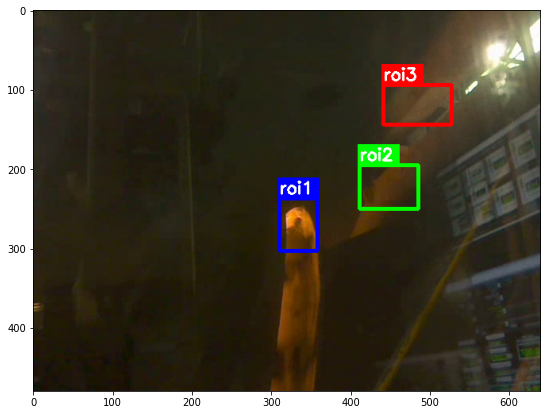

In [16]:
# create/reset value lists
x_vals = []
y_vals = []
y2_vals = []
y3_vals = []
y4_vals = []
y5_vals = []

# create/reset avg lists
avg_image = []
avg_roi1 = []
avg_roi2 = []
avg_roi3 = []

x = 0 # counter
frame_target = 5950 # total frames

# loop through video imagery
while(cap.isOpened() and x < frame_target + 1):
    
    # read in the frame
    ret, frame = cap.read()
    
    # display the 10th frame, with the ROIs overlaid; first few frames are skipped due to auto-exposure function of camera
    if (x == 10):
        
        # draw the ROIs
        col = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        col = drawROI(col, _roi1, (0,0,255))
        col = drawROI(col, _roi2, (0,255,0))
        col = drawROI(col, _roi3, (255,0,0))
        
        # show the ROIs
        plt.figure(figsize=(11, 7))
        plt.imshow(col,cmap='gray')
        plt.show()

    # grab every 30th frame; skipping first 10 while camera adjusts to brightness
    if (x > 49):
        
        # convert image to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        roi1 = gray[_roi1.top:_roi1.top + _roi1.height, _roi1.left:_roi1.left + _roi1.width]
        roi2 = gray[_roi2.top:_roi2.top + _roi2.height, _roi2.left:_roi2.left + _roi2.width]
        roi3 = gray[_roi3.top:_roi3.top + _roi3.height, _roi3.left:_roi3.left + _roi3.width]

        # calculate the average pixel value of the roi
        avg_image.append(cv2.mean(gray)[0])
        avg_roi1.append(cv2.mean(roi1)[0])
        avg_roi2.append(cv2.mean(roi2)[0])
        avg_roi3.append(cv2.mean(roi3)[0])
        
        # on every 50th frame, add the average to the array
        if x % 50 == 0:
            
            #append plot values
            x_vals.append(x)
            y_vals.append(mean(avg_image))
            y2_vals.append(mean(avg_roi1))
            y3_vals.append(mean(avg_roi2))
            y4_vals.append(mean(avg_roi3))
            
            # reset the lists
            avg_image = []
            avg_roi1 = []
            avg_roi2 = []
            avg_roi3 = []
        
    
    #increment frame counter
    x = x + 1
    
# clean up objects otherwise camera becomes inaccessible
cap.release()
cv2.destroyAllWindows()
    
# add PI data to the ROI data; skip first and last for alignment
for p in PI_DATA[1:]:
    y5_vals.append(int(float(p[1])))

<br>

**Step 6. Create dictionary for correlation matrix and trend visualizations.**

In [17]:
#create dictionary
data = {
    'IMG': y_vals,
    'ROI1': y2_vals,
    'ROI2': y3_vals,
    'ROI3': y4_vals,
    'TEMP': y5_vals
}

<br>

**Step 7. Visualize brightness and temperature data.**

This code visualizes the brightness data recorded for the entire image, ROI1, ROI2, ROI3, as well as the temperature reading from PI. There is a clear correlation between the increase in brightness captured by the PICAM and the temperature data imported from the process historian.

<Figure size 432x288 with 0 Axes>

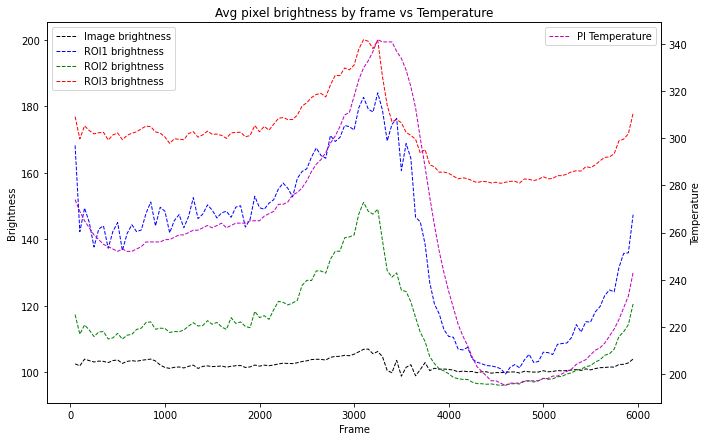

In [19]:
createChart(x_vals,y_vals,y2_vals, y3_vals, y4_vals, y5_vals)

<br>

**Step 8. Create correlation matrix.**

This code creates a correlation matrix, which calculates and visualizes the correlation coefficient between the brightness and tempeature values. The matrix clearly shows that ROI1 has the strongest correlation with the temperature data.

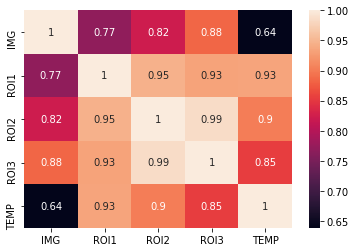

In [22]:
# convert to dataframe
df = pd.DataFrame(data,columns=['IMG','ROI1','ROI2','ROI3','TEMP'])

# calculate correlation coefficient
corrMatrix = df.corr()

#create heatmap
sn.heatmap(corrMatrix, annot=True)

#show plot
plt.show()